<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons
!pip install nlpaug
!pip install tqdm

     |████████████████████████████████| 686kB 7.5MB/s 
     |████████████████████████████████| 399kB 8.6MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import re

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import re
import collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 Data Extraction

### 1.1 Everyday Sexism Project

This is inspired by the data collection work done in paper **[Multi-label Categorization of Accounts of Sexism using a NeuralFramework](https://arxiv.org/abs/1910.04602v4)**

In this paper in order to collect  data, the authours have crawled the Everyday Sexism Project [website](https://everydaysexism.com/), which receives numerous accounts of sexism from survivors themselves as well as observers. 

Here the entries with less than 7 words were removed, post which around 20000 entries were shortlisted for annotation. In this paper, **23 categories** of sexism   were   formulated   taking into  account  gender-related  discourse  and  campaigns as well as possible impact on public policy. We further selected **7 out of 23** categories that are applicable for workplace environment  - ['Attribute stereotyping', 'Role stereotyping', 'Pay gap', 'Hostile work environment', 'Tone policing', 'Moral policing', 'Mansplaining']

In [ ]:
!pip install ipdb

     |████████████████████████████████| 788kB 9.3MB/s 
     |████████████████████████████████| 368kB 37.1MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.8-cp37-none-any.whl size=11599 sha256=7deeecdad7ec374911d0d8dfbabb814be13bf4264263f64591c7eb6c69b6b5e3
  Stored in directory: /root/.cache/pip/wheels/0d/d6/5a/2fdf30b75ca5099e18f66a0a4d439ba031e1aa239e12b39c24
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.24.0 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [ ]:
!apt-get install libmagic-dev
!pip install python-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 1s (289 kB/s)
Selecting previously unselected package libmagic-m

In [ ]:
!pip install ftfy

     |████████████████████████████████| 71kB 5.3MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=5b7f41ad8ddcfa3f3617c8301dea126ca0895145cfc2fef78f570f446c3bdf19
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [ ]:
import re
import urllib.request as urllib2
import os
import ipdb
from bs4 import BeautifulSoup
import time
import sys
import codecs
import pandas as pd
import csv
import json
from os import listdir
from os.path import isfile, join
import io
import magic
import pickle
import ftfy

Here we're scraping the https://everydaysexism.com/ website based on the placeholder IDs provided by the authors in the tsv file.

In [ ]:
tsv_filepath = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data_placeholders.tsv'
data_write_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data.tsv'


def find_post_id(name_box):
    classes = name_box['class']
    for _class in classes:
        if _class[:5] == "post-" and len(_class) > 5:
            return int(_class[5:])
    return -1


def crawl_post(post_page, post_number):
    crawl_page = post_page + str(post_number)

    isCrawledSuccessfully = False
    while not isCrawledSuccessfully:
        try:
            page = urllib2.urlopen(crawl_page).read()
            isCrawledSuccessfully = True
        except urllib2.HTTPError as e:
            if e.code == 404:
                print("\t\t>>> Found 404")
                return None
            else:
                print("\t\t>>> Waitiing for 30 seconds")
                time.sleep(30)
        except Exception:
            print("\t\t>>> Waitiing for 30 seconds")
            time.sleep(30)

    soup = BeautifulSoup(page, 'html.parser')
    name_boxes = soup.find_all('article', attrs={'class': 'post'})
    assert len(name_boxes) == 1
    for i, name_box in enumerate(name_boxes):
        post_id = find_post_id(name_box)
        if post_id == -1:
            print("\t\t>>> ERROR: Error fetching post_id")
            return None
        
        #TODO: VERIFY IF THIS IS CORRECT
        soup = BeautifulSoup(name_box.encode("utf-8"), 'html.parser')
        _name_box = soup.find('div', attrs={'class': 'entry-content'})
        post = _name_box.get_text()
        post = post.replace('\n', '<br/>')
    return post


import re

r_white = re.compile(r'\s+')

xml_csv = open(data_write_path, 'w')
csv_writer = csv.writer(xml_csv, delimiter='\t')
csv_writer.writerow(['post', 'labels'])

post_id_dict = {}

with open(tsv_filepath, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        labels = row[1]
        parts = row[0].split("__")
        post_id__str = parts[0]
        post_offsets__str = [offset.split("_") for offset in parts[1:]]

        if post_id__str in post_id_dict:
            print("accessing " + post_id__str)
            post_text = post_id_dict[post_id__str]
        else:
            print("fetching " + post_id__str)
            post_text = crawl_post("https://everydaysexism.com/everyday-sexism/", post_id__str)
            if post_text == None:
                continue
            post_id_dict[post_id__str] = post_text

        post_text = post_text.replace('<br/>', ' ')
        post_text = re.sub(' +', ' ', post_text)
        post_text = post_text.lstrip()
        post_text__fixed = ftfy.fix_text(post_text)
        text = ""
        for index in range(len(post_offsets__str)):
            text = text + post_text__fixed[int(post_offsets__str[index][0]):int(post_offsets__str[index][1]) + 1]
            if len(post_offsets__str) > 1 and len(post_offsets__str) != index + 1:
                text = text + " "
        text = r_white.sub(' ', text)
        text = text.strip()
        csv_writer.writerow([text, labels])

xml_csv.close()

Here we're filtering the categories relevant to workplace environment.

In [ ]:
df_es = pd.read_csv(data_write_path, sep='\t')

In [ ]:
path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data.tsv'
data = pd.read_csv(path, sep='\t')

In [ ]:
data.head()

,post,labels
0,"My cousin (female, and 14 years older than me)...","Attribute stereotyping, Body shaming, Denial o..."
1,Big brother came to hang out with us toward th...,Sexual assault (excluding rape)
2,"The next morning, I told my friend. She didn't...","Denial or trivialization of sexist misconduct,..."
3,My ex-boyfriend tried guilt tripping me into s...,"Sexual harassment (excluding assault), Slut sh..."
4,While I was working at McDonald's there was th...,"Hostile work environment (excluding pay gap), ..."


In [ ]:
label_list = ['Attribute stereotyping', 'Role stereotyping', 'Pay gap', 'Hostile work environment', 'Tone policing', 'Moral policing', 'Mansplaining']

In [ ]:
def transform(text, label_list):
  for label in label_list:
    if label in text:
      return 1
  return 0

In [ ]:
data['labels'] = data['labels'].apply(transform,label_list=label_list)
data = data[data['labels']==1]

In [ ]:
data.head()

,post,labels
0,"My cousin (female, and 14 years older than me)...",1
4,While I was working at McDonald's there was th...,1
5,I told multiple supervisors and the head of th...,1
6,I worked as a Project Engineer at a major comp...,1
9,"I wanted to go in the forces and was told ""Wom...",1


In [ ]:
# Renaming the columns for consistency
data.rename(columns = {'post':'Sentences', 'labels':'Label'}, inplace=True)

In [ ]:
data.head()

,Sentences,Label
0,"My cousin (female, and 14 years older than me)...",1
4,While I was working at McDonald's there was th...,1
5,I told multiple supervisors and the head of th...,1
6,I worked as a Project Engineer at a major comp...,1
9,"I wanted to go in the forces and was told ""Wom...",1


In [ ]:
print("Total number of samples = ", len(data))

Total number of samples =  6326


In [ ]:
len_list = [len(x) for x in data.Sentences.values]
print("Length of the longest sentence = ", max(len_list))
print("Length of the shortest sentence = ", min(len_list))

Length of the longest sentence =  879
Length of the shortest sentence =  14


In [ ]:
# Saving the final file
data.to_csv('/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/everyday_sexist_comment.csv')

### 1.2 Get tweets labeled with benevolent sexism using twitter API

According to ambivalent sexism theory (Glick and Fiske, 1996), sexism comes in
two forms: Hostile and Benevolent. While hostile sexism is characterized by an explicitly negative attitude, benevolent sexism is more subtle.

The authors collected data using the public Twitter Search
API. The terms queried were common phrases and
hashtags that are generally used when exhibiting
benevolent sexism. Some of them were: ‘as good
as a man’, ‘like a man’, ‘for a girl’, ‘smart for
a girl’, ‘love of a woman’, ‘#adaywithoutwomen’,
‘#womensday’, ‘#everydaysexism’ and ‘#weareequal’.
These lead to a dataset of tweets that were
sexist in nature, both towards women and men.
E.g.: ‘He is a man who can’t act like a man’ is sexist
towards men. Cross-validation and filtering of the benevolent sexist tweets was done by 3 validators. Fleiss’ kappa score was
calculated to assess the reliability of the agreement
between the validators.

We used twitter API to get the tweets corresponding to the tweet ids provided by the author and fetched the dataset (total 7250 tweets) in 3 runs. Then we combined and removed mentions, hashtag symbol and emojis from the tweets. After filtering for retweets and suspended accounts, we had 400 postive label (benevolent) tweets.

**For more information on this dataset, please visit: https://www.aclweb.org/anthology/W17-2902/**

**Enter twitter developer keys which will be used to comminicate to twitter API using tweepy**

In [ ]:
# Twitter Developer keys here
# USED TO COMMUNICATE TO THE TWITTER API
consumer_key = 'XXXXXXXXX'
consumer_key_secret = 'XXXXXXXXX'
access_token = 'XXXXXXXXX'
access_token_secret = 'XXXXXXXXX'


In [ ]:
#set up the API for fetching
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
# This is corpus dataset
#tweet id form (check this tsv for format)
corpusFile = "/content/drive/MyDrive/AI-3 Project/data/NLP_CSS_2017-master/benevolent_sexist.tsv"
df= pd.read_csv(corpusFile, header= None)


**Custom function to fetch tweets and store them as a list (for demonstration we have only fetched 20, but for our task we fetched 7250)**

In [ ]:
# This method creates the training set
def createTrainingSet(corpusFile):
    c=0
    # Get each id as part of the list
    corpus = list(df[0])

    sleepTime = 2
    trainingDataSet = []
    # Do not send more than 1500 ids at once else you will have to wait for 1 hour to cooldown
    for tweet in corpus[0:20]:
        try:
            tweetFetched = api.get_status(tweet) # get the metadeta
            print(c,"Tweet fetched = " + tweetFetched.text)
            c+=1 # counter for seeing which tweet index is being fetched
            time.sleep(sleepTime) # for the API to cool down
            trainingDataSet.append(tweetFetched.text)
        except Exception as e:
            print(c,"Inside the exception - no:2")
            print(e)
            c+=1
            print()
            time.sleep(1)
            continue
                 
    return trainingDataSet
    


In [ ]:
resultFile = createTrainingSet(df)

0 Tweet fetched = RT @GemmaAnneStyles: Happy #womensday to all my sassy women, classy women, nasty women 💋👧🏾💖👩🏼‍🔬👄👵🏼 my fine women, alive women, gonna fight…
1 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

2 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

3 Tweet fetched = RT @girlsreallyrule: The lights are out at the Statue of Liberty...that's ONE MORE woman America CANNOT do without. #adaywithoutwomen #Ligh…
4 Inside the exception - no:2
[{'code': 63, 'message': 'User has been suspended.'}]

5 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

6 Inside the exception - no:2
[{'code': 63, 'message': 'User has been suspended.'}]

7 Inside the exception - no:2
[{'code': 63, 'message': 'User has been suspended.'}]

8 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

9 Inside the exception - no:2
[{'code': 144, 'message': 'No stat

**Convert to dataframe and save**

In [ ]:
res= pd.DataFrame(resultFile)
res.to_csv('first200.csv')
print(res.loc[3][0])

"she parties like a man but loves like a woman"


**Preprocess tweets**

**Import required libraries and datasets**

In [ ]:
csv1= pd.read_csv('first200.csv', header= None)
csv2= pd.read_csv('1500to4520.csv', header= None)
csv3= pd.read_csv('4520.csv', header= None) 

In [ ]:
csv= pd.concat([csv1, csv2, csv3]) #concatenating the files obtained by running for 3 attempts
csv.drop([0], axis=1, inplace= True) #do .head() before to check if 0th col or row has to be removed
csv.drop([0], axis=0, inplace= True)
csv.head()

,1
1,RT @GemmaAnneStyles: Happy #womensday to all m...
2,RT @girlsreallyrule: The lights are out at the...
3,RT @antonioguterres: We can’t achieve any of o...
4,"""she parties like a man but loves like a woman"""
5,RT @GemmaAnneStyles: Happy #womensday to all m...


**Remove retweets**

In [ ]:
csv.drop_duplicates(inplace=True) #duplicate tweets

In [ ]:
print(len(csv))
csv.head()

401


,1
1,RT @GemmaAnneStyles: Happy #womensday to all m...
2,RT @girlsreallyrule: The lights are out at the...
3,RT @antonioguterres: We can’t achieve any of o...
4,"""she parties like a man but loves like a woman"""
6,RT @xanria_018: Lucky is the man who is the fi...


In [ ]:
csv.reset_index(inplace=True)
csv.drop(['index'], axis=1,inplace= True) 

**Remove @mentions along with emojis and website mentions as they are not important for our task**

In [ ]:
def preprocess(df):
  df[1]= [re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', ln) for ln in df[1]] #remove websites
  df[1]= [re.sub(r'http\S+', '', ln) for ln in df[1]] 
  df[1]= [re.sub('@[^\s]+', '', ln) for ln in df[1]] #remove account mentions
  df[1]= [emoji.get_emoji_regexp().sub(u'', ln) for ln in df[1]] #remove emojis
  df[1]= [ln.split() for ln in df[1]] 
  
  for i,ln in enumerate(df[1]):
    try:
      ln.remove('RT') #remove retweets
    except:
      continue
    df.iloc[i,0]=ln
  [print(ln) for ln in df[1]]
  return df

**Remove any null values**

In [ ]:
csv.dropna(inplace= True) #remove any null values
csv= preprocess(csv)
csv.head()

,1
0,"[Happy, #womensday, to, all, my, sassy, women,..."
1,"[The, lights, are, out, at, the, Statue, of, L..."
2,"[We, can’t, achieve, any, of, our, goals, with..."
3,"[""she, parties, like, a, man, but, loves, like..."
4,"[Lucky, is, the, man, who, is, the, first, lov..."


**Rejoin the split strings as they will be tokenized later as per the model requirements**

In [ ]:
csv=csv[1].str.join(" ")

0      Happy #womensday to all my sassy women, classy...
1      The lights are out at the Statue of Liberty......
2      We can’t achieve any of our goals without the ...
3        "she parties like a man but loves like a woman"
4      Lucky is the man who is the first love of a wo...
                             ...                        
396    Literally can eat a whole pizza to myself .......
397    'THE BIGGEST COWARD OF A MAN IS TO AWAKEN THE ...
398    We want to construct a different world of work...
399    Do not awaken the love of a woman, without the...
400    Nothing better in this world than a man making...
Name: 1, Length: 400, dtype: object

**Save the dataset**

In [ ]:
csv.to_csv("Benevolent_sexism.csv")

After cleaning the dataset, these were merged with the workplace sexism dataset to increase the samples and add variability of different sources to it, so that it generalizes well.

## 2 Combining data from multiple sources

#### 2.1 Reading data from multiple sources to a DataFrame

In [ ]:
benevolent_data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/Benevolent_sexism.csv'
sexist_comment_data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/everyday_sexist_comment.csv'
reddit_data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/reddit (1).csv'
isep_data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/ISEP Sexist Data labeling.xlsx'

In [ ]:
original_data = pd.read_excel(isep_data_path)
benevolent_df = pd.read_csv(benevolent_data_path)
sexist_comment_df = pd.read_csv(sexist_comment_data_path)
reddit_df = pd.read_csv(reddit_data_path)

In [ ]:
X = original_data[['Sentences']]
y = original_data['Label']

#### 2.2 Split the data into train, validation and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=66, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, stratify=y_train, random_state=66, shuffle=True)

In [ ]:
train_data = X_train.copy()
train_data['Label'] = y_train

test_data = X_test.copy()
test_data['Label'] = y_test

val_data = X_val.copy()
val_data['Label'] = y_val

In [ ]:
val_data = val_data[val_data['Sentences'].apply(lambda x: len(x.split()) < 1000)]
test_data = test_data[test_data['Sentences'].apply(lambda x: len(x.split()) < 1000)]

In [ ]:
new_benevolent_df = benevolent_df[["1"]]
new_benevolent_df['Label'] = 1

In [ ]:
new_benevolent_df.rename(columns={'1': 'Sentences'}, inplace=True)

In [ ]:
sexist_comment_df = pd.read_csv(sexist_comment_data_path)

In [ ]:
new_sexist_comment_df = sexist_comment_df[['Sentences','Label']]

In [ ]:
reddit_df = pd.read_csv(reddit_data_path)

In [ ]:
new_reddit_df = reddit_df[['body','Sexism']]
new_reddit_df.rename(columns={'body':'Sentences','Sexism':'Label'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##### 2.2.1. Combining all the datasets and filter rows with sentence length less than 1000

In [ ]:
sexist_data = pd.concat([new_benevolent_df, new_sexist_comment_df, new_reddit_df, train_data], axis=0)

In [ ]:
sexist_data = sexist_data[sexist_data['Sentences'].apply(lambda x: len(x.split()) < 1000)]

##### 2.2.2 Clean the dataset

In [ ]:
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  return df

In [ ]:
df = clean_data(sexist_data)
test_data = clean_data(test_data)
val_data = clean_data(val_data)

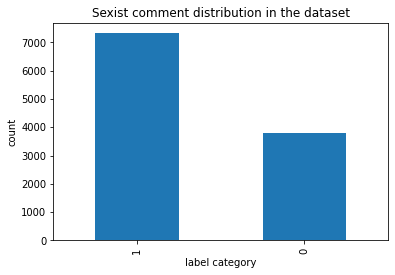

In [ ]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset')
plt.show()

From the above plot, we can see that there is an imbalance in the dataset. Number of negative samples(Non-sexist comments) is almost half of the number of positive samples(Sexist comments) in the dataset.

In [ ]:
df.head()

,Sentences,Label
0,happy womensday to all my sassy women classy w...,1
1,the lights are out at the statue of libertytha...,1
2,we cant achieve any of our goals without the p...,1
3,she parties like a man but loves like a woman,1
4,lucky is the man who is the first love of a wo...,1


##### 2.2.3 Save the train, validation and test sets into different files

In [ ]:
## Saves the cleaned datasets to respective csv files

# df.to_csv('/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/train_dataset.csv')
# test_data.to_csv('/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/test_dataset.csv')
# val_data.to_csv('/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/val_dataset.csv')

In [ ]:
# Load the saved datasets

df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_dataset.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv')
df_val = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv')

## 3 Data Augementation

As seen above, our dataset is imbalanced. To achieve good performance from the models, we need to balance the data. Data augmentation techniques can be used to generate additional, synthetic data using the existing data.
We have used a python library, NLPAug to achieve this.

NLPAug offers three types of augmentation:
1. Character level augmentation
2. Word level augmentation 
3. Sentence level augmentation
Each of these types can be performed with actions like random deletion, random insertion, shuffling, synonym replacement, etc.

Here, we have used synonym replacement action for Word level augmentation, which randomly picks a word from a sentence and replaces it with a synonym of the word( use word embeddings to find most similar group of words to replace original word).



In [ ]:
def augment_text(df,samples=3000,pr=0.2):
  aug = naw.WordEmbsAug(
  model_type='glove', model_path='/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt',
  action="substitute")

  aug.aug_p=pr
  new_text=[]
  
  ##selecting the minority class samples
  df_n=df[df.Label==0].reset_index(drop=True)

  ## data augmentation loop
  for i in tqdm(np.random.randint(0,len(df_n),samples)):
      
          text = df_n.iloc[i]['Sentences']
          augmented_text = aug.augment(text)
          new_text.append(augmented_text)  
  
  new=pd.DataFrame({'Sentences':new_text,'Label':0})
  df=shuffle(df.append(new).reset_index(drop=True))
  return df

In [ ]:
## Uncomment this cell to run Data augmentation on the train dataset

# train = augment_text(df_train)
# train.drop('Unnamed: 0', axis=1, inplace=True)
# train.reset_index(drop=True,inplace=True)

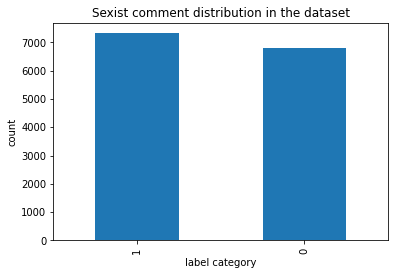

In [ ]:
train['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset after augmentation')
plt.show()

From the above plot, we can see that the class distribution is balanced after data augmentation.

In [ ]:
## Uncomment this cell to save the augmented train data

# train.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [ ]:
# Read the augmented train data

df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [ ]:
X_train = df_train[['Sentences']]
y_train = df_train['Label']

X_val = df_val[['Sentences']]
y_val = df_val['Label']

X_test = df_test[['Sentences']]
y_test = df_test['Label']

In [ ]:
X_train.tail()

,Sentences
14106,having to state your marital status times a d...
14107,my mother commenting on my outfit dont cry to ...
14108,a good man acknowledges a woman than another p...
14109,agree to an extent
14110,joker doesnt even work with a woman besides wa...


In [ ]:
X_train.shape, X_val.shape, X_test.shape

((14111, 1), (273, 1), (228, 1))

## 4 Baseline model with simpleRNN layer

Now that we have a balanced data with upsampled 0 labels, we see the effectiveness of our data in generalizing on postive labels from any source.   

Following the preprocessing of the merged data, we tokenized each sample using the keras tokenizer with a vocab size of 5000. We implemented a SimpleRNN model with an embedding layer as a baseline model and tested its performance on the test dataset. 

We expect the SimpleRNN with its vanishing gradient problem and less context to give a moderate classification performance. 

### 4.1**Tokenizing text with a fixed vocabulary size**

In [ ]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

In [ ]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

### 4.2 **Create tf.Dataset**

In [ ]:
def create_dataset(x,y):
  ragged_x = tf.ragged.constant(x)
  ragged_y = tf.ragged.constant(y)
  dataset = tf.data.Dataset.from_tensor_slices((ragged_x,ragged_y))
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(32)
  dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y), num_parallel_calls=3)
  dataset = dataset.prefetch(3)
  return dataset

In [ ]:
dataset_train = create_dataset(train_data, df_train["Label"])
dataset_val = create_dataset(val_data, df_val["Label"])
dataset_test = create_dataset(test_data, df_test["Label"])

In [ ]:
print(dataset_train)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int64)>


### 4.3 **Define and train model**

In [ ]:
# baseline model

Inputs=  tf.keras.layers.Input(shape=(None,))
Embedding= tf.keras.layers.Embedding(vocab_size, 300)(Inputs)
RNN_1= (tf.keras.layers.SimpleRNN(32, return_sequences=False))(Embedding)
Dense= tf.keras.layers.Dense(1, activation= 'sigmoid')(RNN_1)
model= tf.keras.Model(inputs= Inputs, outputs= Dense)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                10656     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,510,689
Trainable params: 1,510,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history= model.fit(dataset_train, epochs=10, validation_data = dataset_val)

Epoch 1/10
441/441 [==============================] - 51s 112ms/step - loss: 0.6897 - accuracy: 0.5175 - val_loss: 0.6796 - val_accuracy: 0.5751
Epoch 2/10
441/441 [==============================] - 48s 109ms/step - loss: 0.6859 - accuracy: 0.5281 - val_loss: 0.6763 - val_accuracy: 0.5714
Epoch 3/10
441/441 [==============================] - 48s 109ms/step - loss: 0.6853 - accuracy: 0.5306 - val_loss: 0.6829 - val_accuracy: 0.5714
Epoch 4/10
441/441 [==============================] - 48s 107ms/step - loss: 0.6893 - accuracy: 0.5258 - val_loss: 0.6883 - val_accuracy: 0.5421
Epoch 5/10
441/441 [==============================] - 48s 108ms/step - loss: 0.6897 - accuracy: 0.5197 - val_loss: 0.6796 - val_accuracy: 0.5568
Epoch 6/10
441/441 [==============================] - 47s 107ms/step - loss: 0.6875 - accuracy: 0.5302 - val_loss: 0.6790 - val_accuracy: 0.5641
Epoch 7/10
441/441 [==============================] - 48s 108ms/step - loss: 0.6871 - accuracy: 0.5302 - val_loss: 0.6896 - val_ac

**Plotting loss and accuracy**

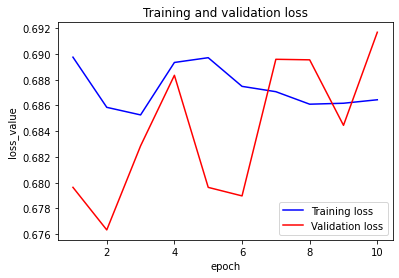

In [ ]:
loss = history.history['loss']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '-r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

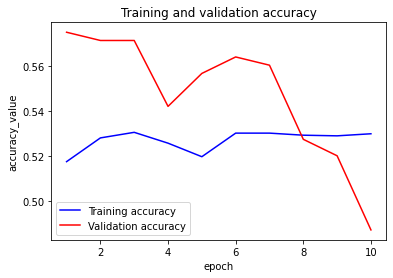

In [ ]:
loss = history.history['accuracy']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training accuracy')
plt.plot(epochs, val_loss, '-r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

**Evaluating on the test dataset**

In [ ]:
result = model.evaluate(dataset_test)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5175


{'accuracy': 0.5175438523292542, 'loss': 0.6889723539352417}

As expected, the model is training ineffectively on data as shown by the plots. This can be attributed to bad generalization to different sources of data in our dataset. Thus this simple model is unable to generalize well. Additionally the test accuracy is extremely less, due to the inefficinecy of the model to capture patterns and key words in our data. 

In [ ]:
#!unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

## 5 ELMo Model

Peter et al. in [Deep contextualized Word Representations](https://arxiv.org/pdf/1802.05365v2.pdf) define 'Embeddings from Language Models', or **ELMo**, as a type of deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). Word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus.

A biLM combines both a forward and backward LM. ELMo jointly maximizes the log likelihood of the forward and backward directions. 

We aim to train ELMo embeddings on our train dataset and do transfer learning to use it as layer in the final model which will predict whether a comment is sexist or not.

### 5.1 Preprocessing for ELMo 

We use tensorflow tokeniser and fit it on the train dataset. We use this tokeniser to convert train, test and val data into tokens.

In [ ]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

We convert the validation and test datasets to their corresponding tokens based on the vocabulary we built.

In [ ]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

We read the glove gender neutral embeddings and convert each of the words in each comment to its corresponding embedding. We do cleaning to remove any words which are not present in the glove gender neutral embeddings.

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
          if w in word_to_vec_map:
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
embedding_path = '/content/drive/MyDrive/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [ ]:
word_to_vec_map["<s>"] = np.random.randn(300)
word_to_vec_map["</s>"] = np.random.randn(300)

In [ ]:
def get_tokens_embedding_list(data, word_to_vec_map, reverse_dictionary):
  embedding_list = []
  tokens_list = []
  for sent_seq in data:
    tensor_list=[]
    token_temp = []
    for token in sent_seq:
      word = reverse_dictionary[token]
      if word in word_to_vec_map:
        tensor_list.append(word_to_vec_map[word])
        token_temp.append(token)
    embedding_list.append(tensor_list)
    tokens_list.append(token_temp)
  return tokens_list ,embedding_list

In [ ]:
X_train_tokens, X_train_embedding = get_tokens_embedding_list(train_data, word_to_vec_map, reverse_dict)
X_val_tokens, X_val_embedding = get_tokens_embedding_list(val_data, word_to_vec_map, reverse_dict)
X_test_tokens, X_test_embedding = get_tokens_embedding_list(test_data, word_to_vec_map, reverse_dict)

### 5.2 Train ELMo Embeddings

We create the dataset to feed into the ELMo Model. We use a bidirectional LSTM with skip connections as our model. We will define a Toy ELMo Model to extract the embeddings from the layers and use that for tranfer learning.

In [ ]:
def transform_pad(input_tensor, input_target, input_N):
    # Transform the input for the f and b LSTM
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    # Transform the target for the f and b LSTM
    target_f  = input_target[:,1:]
    target_b  = input_target[:,:-1]
    
    # Pad the inputs
    input_f  = input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b  = input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    # Pad the targets
    target_f = target_f.to_tensor(default_value=0, shape=[None, None])
    target_b = target_b.to_tensor(default_value=0, shape=[None, None])
    
    return (input_f, input_b, input_N), (target_f, target_b)

def create_dataset(data_in, target_in):
   
    N = [len(n) for n in data_in]
    
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    ragged_target = tf.ragged.constant(target_in, tf.int32)

    tensor_N = tf.constant(N, tf.int32)
    
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, ragged_target, tensor_N))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    dataset = dataset.map(transform_pad,  num_parallel_calls=4)
                          
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
index = len(X_train_tokens)//2
dataset_train_1 = create_dataset(X_train_embedding[:index], X_train_tokens[:index])
dataset_train_2 = create_dataset(X_train_embedding[index:], X_train_tokens[index:])
dataset_train = dataset_train_1.concatenate(dataset_train_2)
dataset_val  = create_dataset(X_val_embedding, X_val_tokens)

In [ ]:
h_size = 150

tf.keras.backend.clear_session()

inputs_f = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_b = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_N = tf.keras.Input(shape=(), dtype=tf.int32)

masked_f = tf.keras.layers.Masking()(inputs_f)
masked_b = tf.keras.layers.Masking()(inputs_b)

RNN1_f = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=False)
h1_f = RNN1_f(masked_f)

proyection_Wf = tf.keras.layers.Dense(RNN1_f.units, name='Res_Wf', activation=None)
residual1_f = h1_f + proyection_Wf(masked_f)


RNN2_f = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=False)
h2_f = RNN2_f(residual1_f)

Dense = tf.keras.layers.Dense(vocab_size+1, activation='softmax')

pred_f = Dense(h2_f)

RNN1_b = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=True)
h1_b = RNN1_b(masked_b)

proyection_Wb = tf.keras.layers.Dense(RNN1_b.units, name='Res_Wb', activation=None)
residual1_b = h1_b + proyection_Wb(masked_b)

RNN2_b = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=True)
h2_b = RNN2_b(residual1_b)

pred_b = Dense(h2_b)

model = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs = (pred_f, pred_b) )
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
222/222 [==============================] - 59s 216ms/step - loss: 3.5638 - dense_loss: 1.7776 - dense_1_loss: 1.7862 - dense_accuracy: 0.8866 - dense_1_accuracy: 0.8871 - val_loss: 5.3292 - val_dense_loss: 2.6702 - val_dense_1_loss: 2.6591 - val_dense_accuracy: 0.5792 - val_dense_1_accuracy: 0.6115
Epoch 2/10
222/222 [==============================] - 46s 208ms/step - loss: 2.0517 - dense_loss: 1.0299 - dense_1_loss: 1.0218 - dense_accuracy: 0.8936 - dense_1_accuracy: 0.8963 - val_loss: 5.2492 - val_dense_loss: 2.6696 - val_dense_1_loss: 2.5796 - val_dense_accuracy: 0.5823 - val_dense_1_accuracy: 0.6093
Epoch 3/10
222/222 [==============================] - 47s 213ms/step - loss: 1.9464 - dense_loss: 0.9780 - dense_1_loss: 0.9684 - dense_accuracy: 0.8993 - dense_1_accuracy: 0.9032 - val_loss: 4.9692 - val_dense_loss: 2.5331 - val_dense_1_loss: 2.4362 - val_dense_accuracy: 0.6089 - val_dense_1_accuracy: 0.6382
Epoch 4/10
222/222 [==============================] - 47s 213ms/ste

In [ ]:
# For the output of Toy_Elmo, we have to extract the embeddings for each word.
# We have to remove the embeddings for <s> and </s>.
# And we have to invert the backwards LSTM embeddings.

# First we remove the </s> token from the backwards hidden states
mask1 = tf.sequence_mask(inputs_N-2, tf.shape(h1_b)[1]) 
mask2 = tf.math.logical_not(tf.sequence_mask(inputs_N -1,tf.shape(h1_b)[1])) 
mask = tf.math.logical_or(mask1, mask2)

# We invert the backwards embeddings
h1_b = h1_b[:,::-1,:]
h2_b = h2_b[:,::-1,:]
h1_b_m = tf.reshape(h1_b[mask],(tf.shape(h1_b)[0], tf.shape(h1_b)[1]-1, h_size) )
h2_b_m = tf.reshape(h2_b[mask],(tf.shape(h2_b)[0], tf.shape(h2_b)[1]-1, h_size) )


# Concatenate the embeddings
# Note that we skip the first element in the forward embeddings
# since the first token contains the hidden state of the <s>
h1 = tf.keras.layers.Concatenate(axis=2)([h1_f[:,1:,:], h1_b_m])
h2 = tf.keras.layers.Concatenate(axis=2)([h2_f[:,1:,:], h2_b_m])

# We extract the w2v embeddings from the forward input
# removing the first element corresponding to the <s> token.
w2v_emb = masked_f[:,1:,:]

Toy_ELMo = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs = (w2v_emb, h1, h2) )

In [ ]:
for i in dataset_train:
    result = Toy_ELMo(i[0])
    break

In [ ]:
result[0].shape, result[1].shape, result[2].shape

(TensorShape([64, 866, 300]),
 TensorShape([64, 866, 300]),
 TensorShape([64, 866, 300]))

### 5.3 Transfer Learning:

We use the train and validation dataset and convert it into a dataset object which can be used further for training the model. We define a Sauce layer to learn the embeddings for elmo from our dataset. The model will predict whether the comment is sexist or not.

In [ ]:
def transform_pad(input_tensor, input_N, class_target):
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    input_f  = input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b  = input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    return (input_f, input_b, input_N), class_target

def create_dataset(data_in, target_in):
   
    N = [len(n) for n in data_in]
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    class_target = tf.ragged.constant(target_in, tf.int32)
    tensor_N = tf.constant(N, tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, tensor_N, class_target))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(128)
    dataset = dataset.map(transform_pad, num_parallel_calls=4)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
sexism_train = create_dataset(X_train_embedding, df_train["Label"])
sexism_val = create_dataset(X_val_embedding, df_val["Label"])
sexism_test = create_dataset(X_test_embedding, df_test["Label"])

In [ ]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, input_shape):
        self.scale = tf.Variable(tf.nn.softmax([0.4,0.3,0.3]), trainable=True)
    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.tensordot(scale_norm, inputs, axes=1)

In [ ]:
tf.keras.backend.clear_session()
Toy_ELMo.trainable=False
# Define the inputs
inputs_f = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_b = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_N = tf.keras.Input(shape=(), dtype=tf.int32)

# Get the embeddings
e0,e1,e2 = Toy_ELMo((inputs_f, inputs_b, inputs_N))

# Make the sauce
Sauce_layer = ScaleLayer(3)
sauce = Sauce_layer(tf.stack([e0,e1,e2]))

# Define the masking
masked_sauce = tf.keras.layers.Masking()(sauce)

# Define the forward LSTM
RNN1_f = tf.keras.layers.LSTM(300, return_sequences=True, go_backwards=False)
h1_f = RNN1_f(masked_sauce)

RNN2_f = tf.keras.layers.LSTM(300, return_sequences=False, go_backwards=False)
h2_f = RNN2_f(h1_f)

pred = tf.keras.layers.Dense(2, activation='softmax')(h2_f)

model3 = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs=pred)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

In [ ]:
history3 = model3.fit(sexism_train, epochs=20, validation_data=sexism_val)

Epoch 1/20
111/111 [==============================] - 45s 293ms/step - loss: 0.6566 - accuracy: 0.6208 - val_loss: 0.7591 - val_accuracy: 0.4469
Epoch 2/20
111/111 [==============================] - 29s 262ms/step - loss: 0.6121 - accuracy: 0.6756 - val_loss: 0.7678 - val_accuracy: 0.4762
Epoch 3/20
111/111 [==============================] - 30s 271ms/step - loss: 0.6005 - accuracy: 0.6817 - val_loss: 0.8506 - val_accuracy: 0.4579
Epoch 4/20
111/111 [==============================] - 30s 268ms/step - loss: 0.5929 - accuracy: 0.6907 - val_loss: 0.8265 - val_accuracy: 0.4762
Epoch 5/20
111/111 [==============================] - 30s 268ms/step - loss: 0.5840 - accuracy: 0.6904 - val_loss: 0.7508 - val_accuracy: 0.4835
Epoch 6/20
111/111 [==============================] - 31s 273ms/step - loss: 0.5755 - accuracy: 0.6981 - val_loss: 0.7756 - val_accuracy: 0.4945
Epoch 7/20
111/111 [==============================] - 30s 271ms/step - loss: 0.5649 - accuracy: 0.7046 - val_loss: 0.8271 - val_ac

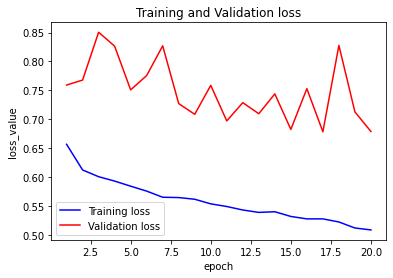

In [ ]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1,len(train_loss)+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

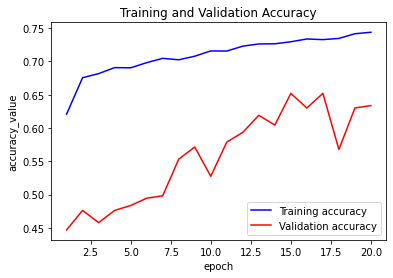

In [ ]:
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1,len(train_acc)+1)

plt.figure()
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

In [ ]:
result = model3.evaluate(sexism_test)
dict(zip(model3.metrics_names, result))

2/2 [==============================] - 0s 20ms/step - loss: 0.7032 - accuracy: 0.6360


{'accuracy': 0.6359649300575256, 'loss': 0.7032281756401062}